In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# 1. Load data

In [3]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")

In [4]:
print("Train shape:",train.shape)
print("Test shape:",test.shape)

Train shape: (891, 12)
Test shape: (418, 11)


In [4]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
cat_cols=train.select_dtypes(include="object").columns
num_cols=train.select_dtypes(exclude="object").columns

In [6]:
cat_cols

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

In [7]:
num_cols

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

# 2. Feature exploration

## 2.1 Pclass

**Categoric ordinal feature:** we assume that 1 class passenger it's more expensive than 2 and 3.

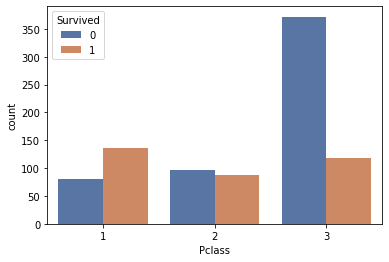

In [10]:
sns.countplot(train["Pclass"],hue=train["Survived"],palette="deep")
plt.show()

In [11]:
((train.groupby("Pclass")["Survived"].sum()/train.groupby("Pclass")["Survived"].count())*100).reset_index(name="% survived")

,Pclass,% survived
0,1,62.962963
1,2,47.282609
2,3,24.236253


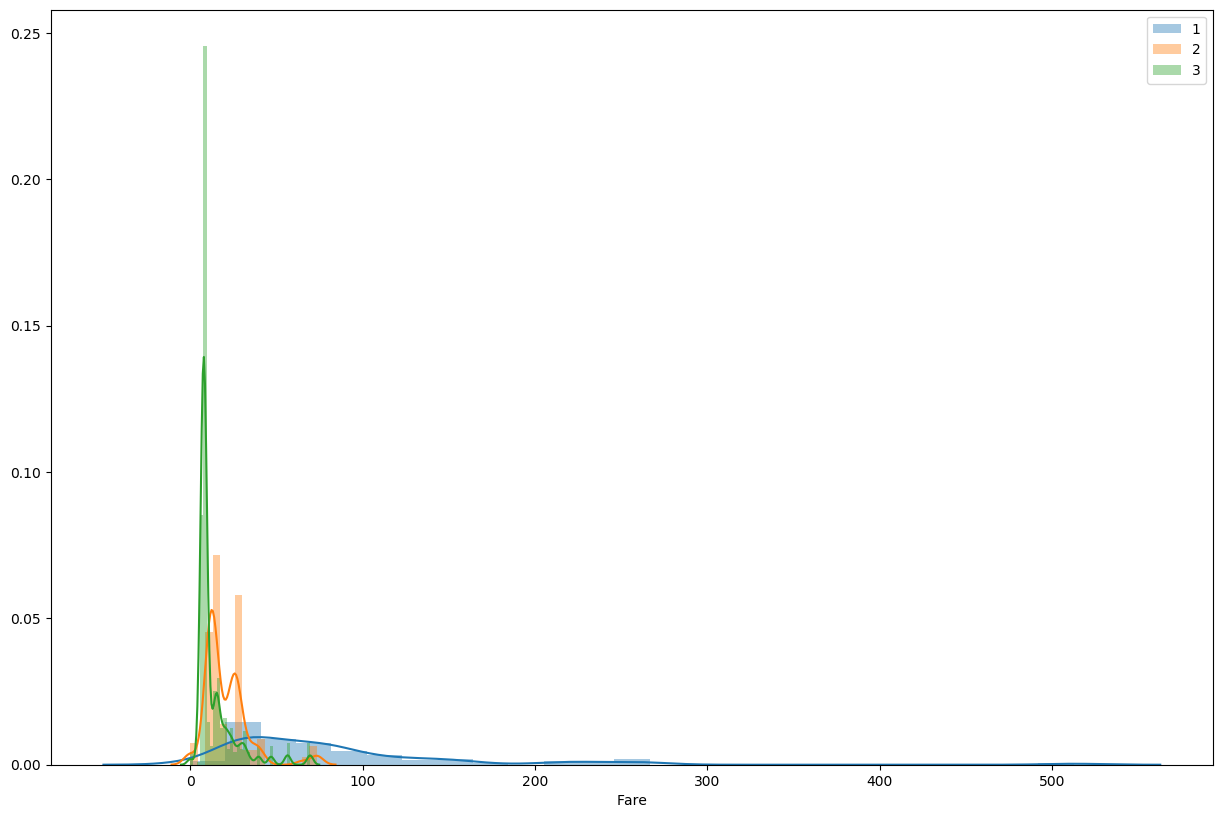

In [12]:
plt.figure(figsize=(15,10),dpi=100)
sns.distplot(train[train["Pclass"]==1]["Fare"],label=1)
sns.distplot(train[train["Pclass"]==2]["Fare"],label=2)
sns.distplot(train[train["Pclass"]==3]["Fare"],label=3)
plt.legend()
plt.show()

In [13]:
train.groupby('Pclass')['Fare'].describe() 

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


- Clearly, there is a relation between Pclass and the ticket fare. Also we can see that the fare for the 1 class has more std than 2 and 3.
- See if deleting fare of class 1 outliers improves the model

In [14]:
train["Pclass"].isna().sum()

0

In [15]:
test["Pclass"].isna().sum()

0

## 2.2 Age
Numeric feature

In [16]:
train["Age"].unique()

array([22.  , 38.  , 26.  , 35.  ,   nan, 54.  ,  2.  , 27.  , 14.  ,
        4.  , 58.  , 20.  , 39.  , 55.  , 31.  , 34.  , 15.  , 28.  ,
        8.  , 19.  , 40.  , 66.  , 42.  , 21.  , 18.  ,  3.  ,  7.  ,
       49.  , 29.  , 65.  , 28.5 ,  5.  , 11.  , 45.  , 17.  , 32.  ,
       16.  , 25.  ,  0.83, 30.  , 33.  , 23.  , 24.  , 46.  , 59.  ,
       71.  , 37.  , 47.  , 14.5 , 70.5 , 32.5 , 12.  ,  9.  , 36.5 ,
       51.  , 55.5 , 40.5 , 44.  ,  1.  , 61.  , 56.  , 50.  , 36.  ,
       45.5 , 20.5 , 62.  , 41.  , 52.  , 63.  , 23.5 ,  0.92, 43.  ,
       60.  , 10.  , 64.  , 13.  , 48.  ,  0.75, 53.  , 57.  , 80.  ,
       70.  , 24.5 ,  6.  ,  0.67, 30.5 ,  0.42, 34.5 , 74.  ])

In [17]:
train[train["Age"]<1]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S


- There are some nan and float numbers, for an age make no sense. 
- Ages less than one are children (Master and Miss titles)

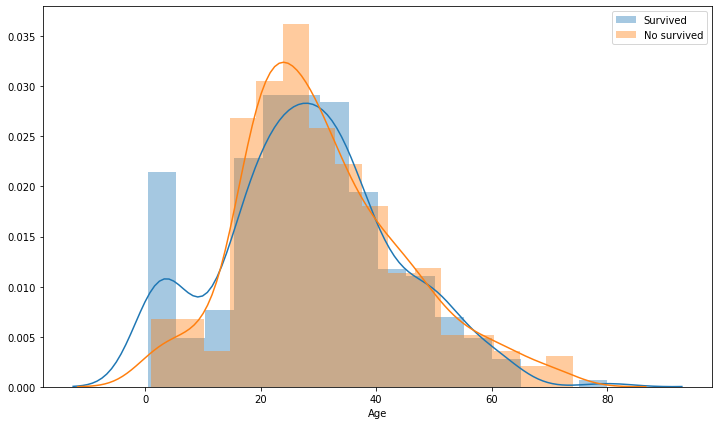

In [18]:
plt.figure(figsize=(12,7))
sns.distplot(train[train["Survived"]==1]["Age"],label="Survived")
sns.distplot(train[train["Survived"]==0]["Age"],label="No survived")
plt.legend()
plt.show()

In [19]:
train.groupby('Survived')['Age'].describe() 

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
1,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


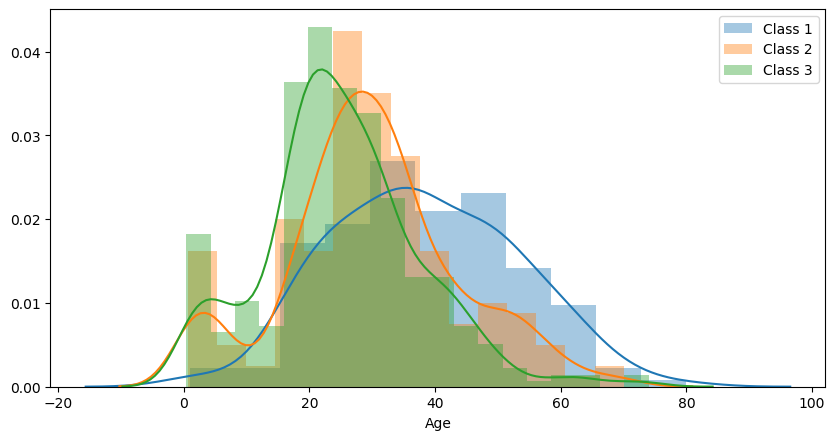

In [20]:
plt.figure(figsize=(10,5),dpi=100)
sns.distplot(train[train["Pclass"]==1]["Age"],label="Class 1")
sns.distplot(train[train["Pclass"]==2]["Age"],label="Class 2")
sns.distplot(train[train["Pclass"]==3]["Age"],label="Class 3")
plt.legend()
plt.show()

In [21]:
train.groupby('Pclass')['Age'].describe() 

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,186.0,38.233441,14.802856,0.92,27.0,37.0,49.0,80.0
2,173.0,29.877630,14.001077,0.67,23.0,29.0,36.0,70.0
3,355.0,25.140620,12.495398,0.42,18.0,24.0,32.0,74.0


In [22]:
train["Age"].isna().sum()

177

In [23]:
test["Age"].isna().sum()

86

- People in class 1 were older than the other classes
- After getting the titles, fill nan in ages according their titles
- Feature idea after runnig the model to see changes on accuracy: less 18, young, adult, old

## 2.3 Sex
Categorical feature

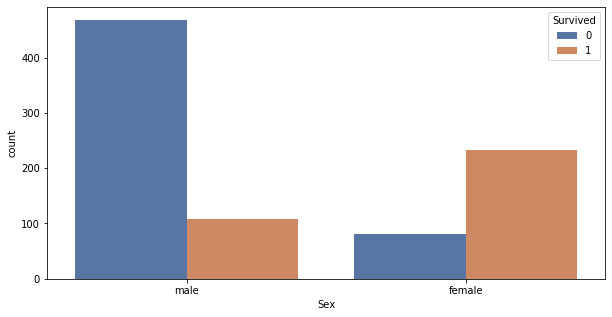

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(train["Sex"],hue=train["Survived"],palette="deep")
plt.show()

In [25]:
((train.groupby("Sex")["Survived"].sum()/train.groupby("Sex")["Survived"].count())*100).reset_index(name="% survived") 

,Sex,% survived
0,female,74.203822
1,male,18.890815


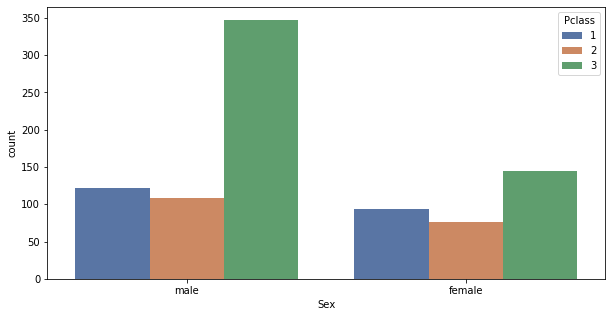

In [26]:
plt.figure(figsize=(10,5))
sns.countplot(train["Sex"],hue=train["Pclass"],palette="deep")
plt.show()

In [27]:
train["Sex"].isna().sum()

0

In [28]:
test["Sex"].isna().sum()

0

## 2.4 SibSp and Parch
- Numeric features
- Creating a feature that capture the two features might improve the model accuracy

In [8]:
train["Group size"]=train["SibSp"]+train["Parch"]
test["Group size"]=test["SibSp"]+test["Parch"]

In [9]:
train["Group size"].unique()

array([ 1,  0,  4,  2,  6,  5,  3,  7, 10])

In [10]:
train["Group type"]=np.where(train["Group size"]==0,"Alone",np.where(train["Group size"]<2,"Couple",np.where(train["Group size"]<5,"Small group","Big group")))
test["Group type"]=np.where(test["Group size"]==0,"Alone",np.where(test["Group size"]<2,"Couple",np.where(test["Group size"]<5,"Small group","Big group")))

In [11]:
#train.drop(["Group size","SibSp","Parch"],axis=1,inplace=True)
#test.drop(["Group size","SibSp","Parch"],axis=1,inplace=True)

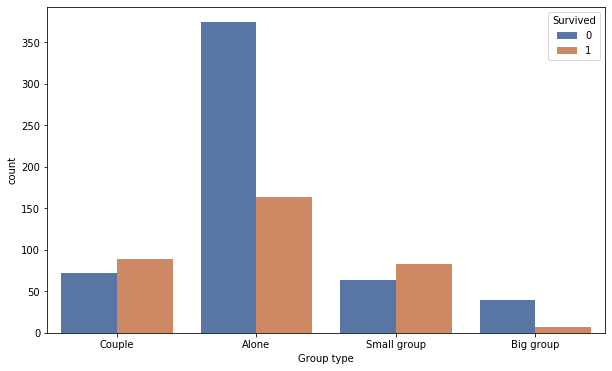

In [33]:
plt.figure(figsize=(10,6))
sns.countplot(train["Group type"],hue=train["Survived"],palette="deep")
plt.show()

In [34]:
((train.groupby("Group type")["Survived"].sum()/train.groupby("Group type")["Survived"].count())*100).reset_index(name="% survived") 

,Group type,% survived
0,Alone,30.353818
1,Big group,14.893617
2,Couple,55.279503
3,Small group,56.849315


In [35]:
train["Group type"].isna().sum()

0

In [36]:
test["Group type"].isna().sum()

0

## 2.5 Cabin

In [37]:
print("The {0}% of the rows have NaNs in this feature".format(round(train["Cabin"].isna().sum()/len(train)*100)))

The 77.0% of the rows have NaNs in this feature


- We can try to fill with U (Unknow)
- We can try fill with the mode
- We can try to fill it with the cabin of a relative

In [12]:
train["Cabin letter"]=train["Cabin"].str.get(0)
test["Cabin letter"]=test["Cabin"].str.get(0)

We have to be careful making dummies features, because are some cabins that are not listed on test set

In [13]:
train["Cabin letter"].fillna("U",inplace=True)
test["Cabin letter"].fillna("U",inplace=True)

In [14]:
train.drop("Cabin",inplace=True,axis=1)
test.drop("Cabin",inplace=True,axis=1)

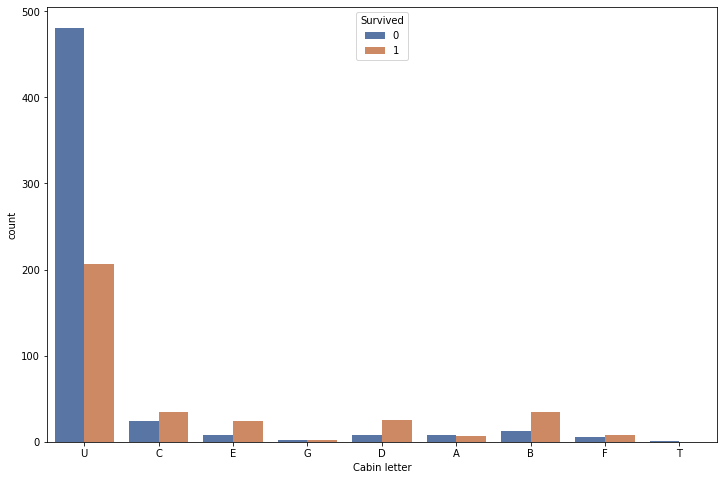

In [41]:
plt.figure(figsize=(12,8))
sns.countplot(train["Cabin letter"],hue=train["Survived"],palette="deep")
plt.show()

In [42]:
((train.groupby("Cabin letter")["Survived"].sum()/train.groupby("Cabin letter")["Survived"].count())*100).reset_index(name="% survived").sort_values(by="% survived",ascending=False) 

,Cabin letter,% survived
3,D,75.757576
4,E,75.000000
1,B,74.468085
5,F,61.538462
2,C,59.322034
6,G,50.000000
0,A,46.666667
8,U,29.985444
7,T,0.000000


- People in cabin D, E and B have more probabilities to survive
- After running model, this feature could be modified in order to see some changes on accuracy

## 2.6 Embarked

In my opinion, this features is useless

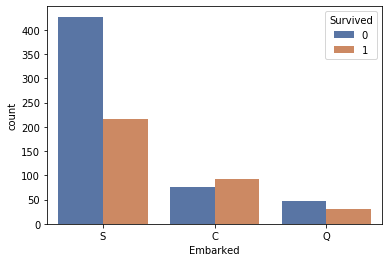

In [43]:
sns.countplot(train["Embarked"],hue=train["Survived"],palette="deep")
plt.show()

In [44]:
train["Embarked"].isna().sum()

2

In [45]:
test["Embarked"].isna().sum()

0

Those two NaNs are going to be filled with the mode

In [15]:
train["Embarked"].fillna(train["Embarked"].mode()[0],inplace=True)

## 2.7 Fare
- We already saw that fare-class are related, plotting fare-cabin can be useful to understand how to fill NaN if exists
- Also we saw some outliers, trying some cuts on those might improve the model accuracy

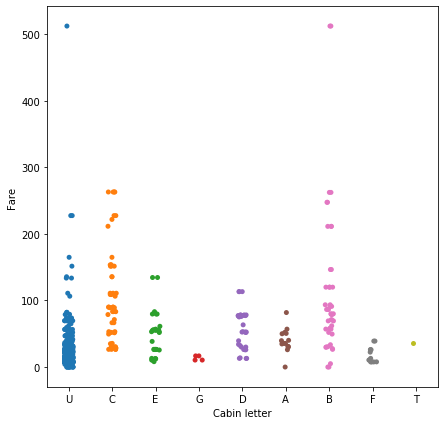

In [47]:
plt.figure(figsize=(7,7))
sns.stripplot(train["Cabin letter"],train["Fare"])
plt.show()

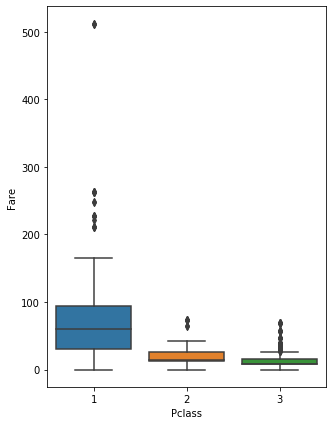

In [48]:
plt.figure(figsize=(5,7))
sns.boxplot(train["Pclass"],train["Fare"])
plt.show()

In [49]:
test["Fare"].isna().sum()

1

The NaN in test set will be filled whith the mean of fares that have the same class and cabin

In [50]:
test[pd.isnull(test["Fare"])]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Group size,Group type,Cabin letter
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,S,0,Alone,U


In [16]:
test["Fare"].fillna(train[(train["Pclass"]==3)&(train["Cabin letter"]=="U")]["Fare"].mean(),inplace=True)

## 2.8 Ticket
Useful to find some relation between families and friends, like the lastname.

In [17]:
train["Ticket number"]=pd.DataFrame(train["Ticket"].apply(lambda x: x.split(' ')[-1])) 
test["Ticket number"]=pd.DataFrame(test["Ticket"].apply(lambda x: x.split(' ')[-1]))
#there is one ticket number filled with LINE

In [18]:
train["Ticket number"].replace({"LINE": 0}, inplace=True)

In [19]:
train.drop("Ticket",axis=1,inplace=True)
test.drop("Ticket",axis=1,inplace=True)

In [20]:
train["Ticket number"].value_counts()

347082     7
1601       7
2343       7
2144       6
3101295    6
          ..
11769      1
349201     1
21440      1
3474       1
330932     1
Name: Ticket number, Length: 679, dtype: int64

There are some tickets that have the same number. (???)

## 2.9 Name
- Here we are going to extract the title, and the lastname

In [21]:
names={"Capt":"Officer",
       "Col":"Officer",
       "Major":"Officer",
       "Jonkheer":"Royalty",
       "Don":"Royalty",
       "Sir":"Royalty",
       "Dr":"Officer",
       "Rev":"Officer",
       "the Countess":"Royalty",
       "Dona":"Royalty",
       "Mme":"Mrs",
       "Mlle":"Miss",
       "Ms":"Mrs",
       "Mr":"Mr",
       "Mrs":"Mrs",
       "Miss" :"Miss",
       "Master":"Master",
       "Lady":"Royalty"}

First, extact the lastname

In [22]:
train["Lastname"]=train["Name"].str.split(",",expand=True)[0]
test["Lastname"]=test["Name"].str.split(",",expand=True)[0]

Now, extract and transform the title

In [23]:
train["Title"]=train["Name"].str.split(",",expand=True)[1].str.split(".",expand=True)[0].str.strip()
test["Title"]=test["Name"].str.split(",",expand=True)[1].str.split(".",expand=True)[0].str.strip()

In [24]:
train["Title"]=train["Title"].map(names)
test["Title"]=test["Title"].map(names)

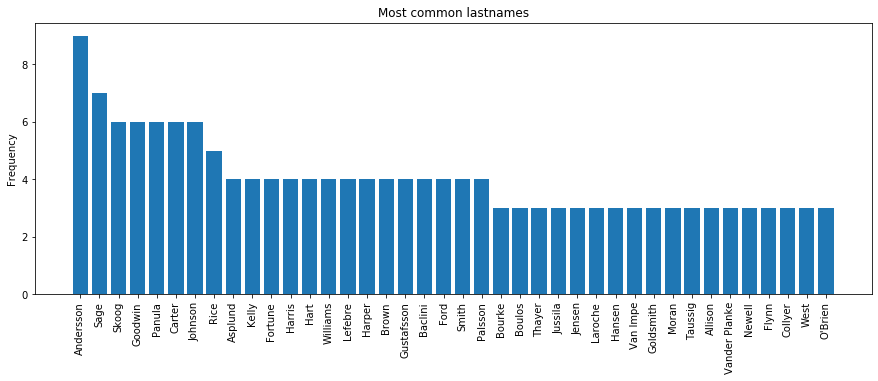

In [60]:
lastnames=train["Lastname"].value_counts().reset_index(name="N").sort_values(by="N",ascending=False)
plt.figure(figsize=(15,5))
plt.bar(lastnames.head(40)["index"],height=lastnames.head(40)["N"])
plt.xticks(rotation=90)
plt.ylabel("Frequency")
plt.title("Most common lastnames")
plt.show()

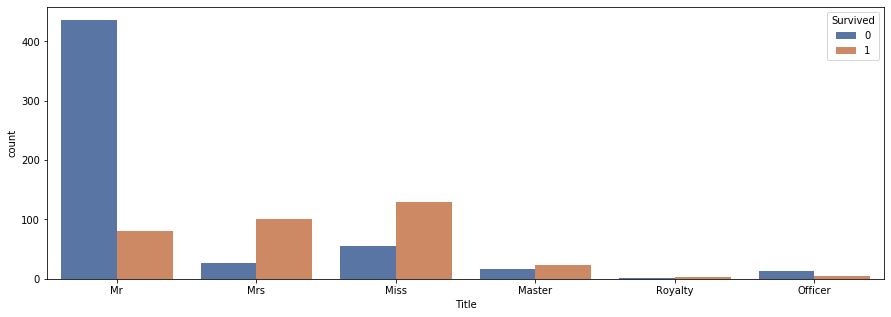

Total percetage of titles


Mr         58.024691
Miss       20.650954
Mrs        14.253648
Master      4.489338
Officer     2.020202
Royalty     0.561167
Name: Title, dtype: float64

In [61]:
plt.figure(figsize=(15,5))
sns.countplot(train["Title"],palette="deep",hue=train["Survived"])
plt.show()

print("Total percetage of titles")
train["Title"].value_counts()/len(train)*100

In [62]:
print("Age statistics for each title")
train.groupby("Title")["Age"].describe()

Age statistics for each title


,count,mean,std,min,25%,50%,75%,max
Title,,,,,,,,
Master,36.0,4.574167,3.619872,0.42,1.000,3.5,8.0,12.0
Miss,148.0,21.804054,12.904198,0.75,14.375,21.0,30.0,63.0
Mr,398.0,32.368090,12.708793,11.00,23.000,30.0,39.0,80.0
Mrs,110.0,35.718182,11.409100,14.00,27.250,35.0,44.0,63.0
Officer,17.0,46.705882,12.819734,23.00,42.000,50.0,54.0,70.0
Royalty,5.0,41.600000,6.804410,33.00,38.000,40.0,48.0,49.0


# 3. Preprocessing
Now that we have an idea about the data, we are going to fill NaNs, scaling numeric values and create some dummies variables

# 3.1 - NaNs

There are some missing values in age feature. So, after taking the mean for each title we input those values to the missing values, depeding on the title.

In [25]:
train["Age"]=np.where( (np.isnan(train["Age"])) & (train["Title"]=="Mr"),round(train[train["Title"]=="Mr"]["Age"].mean()),train["Age"])
train["Age"]=np.where( (np.isnan(train["Age"])) & (train["Title"]=="Master"),round(train[train["Title"]=="Master"]["Age"].mean()),train["Age"])
train["Age"]=np.where( (np.isnan(train["Age"])) & (train["Title"]=="Miss"),round(train[train["Title"]=="Miss"]["Age"].mean()),train["Age"])
train["Age"]=np.where( (np.isnan(train["Age"])) & (train["Title"]=="Mrs"),round(train[train["Title"]=="Mrs"]["Age"].mean()),train["Age"])
train["Age"]=np.where( (np.isnan(train["Age"])) & (train["Title"]=="Officer"),round(train[train["Title"]=="Officer"]["Age"].mean()),train["Age"])
train["Age"]=np.where( (np.isnan(train["Age"])) & (train["Title"]=="Royalty"),round(train[train["Title"]=="Royalty"]["Age"].mean()),train["Age"])


test["Age"]=np.where( (np.isnan(test["Age"])) & (test["Title"]=="Mr"),round(train[train["Title"]=="Mr"]["Age"].mean()),test["Age"])
test["Age"]=np.where( (np.isnan(test["Age"])) & (test["Title"]=="Master"),round(train[train["Title"]=="Master"]["Age"].mean()),test["Age"])
test["Age"]=np.where( (np.isnan(test["Age"])) & (test["Title"]=="Miss"),round(train[train["Title"]=="Miss"]["Age"].mean()),test["Age"])
test["Age"]=np.where( (np.isnan(test["Age"])) & (test["Title"]=="Mrs"),round(train[train["Title"]=="Mrs"]["Age"].mean()),test["Age"])
test["Age"]=np.where( (np.isnan(test["Age"])) & (test["Title"]=="Officer"),round(train[train["Title"]=="Officer"]["Age"].mean()),test["Age"])
test["Age"]=np.where( (np.isnan(test["Age"])) & (test["Title"]=="Royalty"),round(train[train["Title"]=="Royalty"]["Age"].mean()),test["Age"])

Now, we can create a new feature with the age.

In [26]:
train["Age group"]=np.where(train["Age"]<18,"Child",np.where(train["Age"]<45,"Young adult",np.where(train["Age"]<60,"Middle-age","Old")))
test["Age group"]=np.where(test["Age"]<18,"Child",np.where(test["Age"]<45,"Young adult",np.where(test["Age"]<60,"Middle-age","Old")))

In [27]:
train.drop("Name",inplace=True,axis=1)
test.drop("Name",inplace=True,axis=1)

## 3.2 - Scaling and encoding pipeline

In [28]:
#train.drop("PassengerId",axis=1,inplace=True)
#test.drop("PassengerId",axis=1,inplace=True)
train["Ticket number"]=train["Ticket number"].astype(int)
test["Ticket number"]=test["Ticket number"].astype(int)

In [29]:
X=train.drop("Survived",axis=1)
Y=train["Survived"]

num_cols = ['Age',"Ticket number","PassengerId"]
cat_cols = ['Sex', 'Pclass',"Group type",
            "Group size","Title"]

X=X[num_cols+cat_cols]

preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), num_cols),
                                                ('cat', OneHotEncoder(), cat_cols)])

# 4. Models creation

## 4.1 XGBClassifier

In [79]:
xgb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier())])

param = {
    'classifier__n_estimators': [50, 100, 150, 200, 250],
    'classifier__learning_rate': [0.01,0.05,0.1,0.5],
    "classifier__max_depth":[4,5,6,7,8]
}
xgb_search = GridSearchCV(xgb_pipe, param, n_jobs=-1,cv=5,scoring="accuracy")
xgb_search.fit(X, Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['Age',
                                                                          'Ticket '


In [80]:
xgb_search.best_score_

0.8271608813006089

In [81]:
xgb_search.best_params_

{'classifier__learning_rate': 0.01,
 'classifier__max_depth': 4,
 'classifier__n_estimators': 150}

In [30]:
xgb=XGBClassifier(n_estimators=150,learning_rate=0.01,max_depth=4)

## 4.2 RandomForestClassifier

In [87]:
forest_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('forest', RandomForestClassifier())])

param = {
    'forest__n_estimators': [50, 100, 150, 200, 250],
    'forest__min_samples_leaf': [1,2,3,4],
    "forest__max_depth":[4,5,6,7,8],
    "forest__max_features":[0.5,"sqrt","log2"]
}
forest_search = GridSearchCV(forest_pipe, param, n_jobs=-1,cv=5,scoring="accuracy")
forest_search.fit(X, Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['Age',
                                                                          'Ticket '


In [89]:
forest_search.best_score_

0.8339150084740444

In [90]:
forest_search.best_params_

{'forest__max_depth': 6,
 'forest__max_features': 0.5,
 'forest__min_samples_leaf': 3,
 'forest__n_estimators': 250}

In [33]:
forest=RandomForestClassifier(n_estimators=250,min_samples_leaf=3,max_depth=6,max_features=0.5)

## 4.3 SVC

In [101]:
svc_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('svc', SVC())])

param = {
    'svc__kernel': ["rbf"],
    "svc__C": [1,100,1000,10000],
    "svc__gamma":[0.001,0.01],
}
svc_search = GridSearchCV(svc_pipe, param, n_jobs=-1,cv=5,scoring="accuracy")
svc_search.fit(X, Y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         StandardScaler(copy=True,
                                                                                        with_mean=True,
                                                                                        with_std=True),
                                                                         ['Age',
                                                                          'Ticket '


In [102]:
svc_search.best_score_

0.8293829640323898

In [103]:
svc_search.best_params_

{'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}

In [34]:
svc=SVC(kernel="rbf",C=100,gamma=0.01)

## 4.4 Model stacking

In [35]:
learners=[("xgb",xgb),("forest",forest),("svc",svc)]
meta_learner=StackingClassifier(estimators=learners,final_estimator=LogisticRegression())

In [113]:
%time scores=cross_val_score(meta_learner,preprocessor.fit_transform(X),Y,cv=10,scoring="accuracy")

CPU times: user 1min 22s, sys: 650 ms, total: 1min 23s
Wall time: 1min 3s


In [114]:
print(scores.mean())

0.8361423220973784


## 4.5 Model evaluation

#### 4.5.1 Classification report and confusion matrix

In [38]:
meta_learner.fit(preprocessor.fit_transform(X),Y)

StackingClassifier(cv=None,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=0.01,
                                              max_delta_step=None, max_depth=4,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estima...
                          

In [41]:
cm=confusion_matrix(Y,meta_learner.predict(preprocessor.fit_transform(X)))

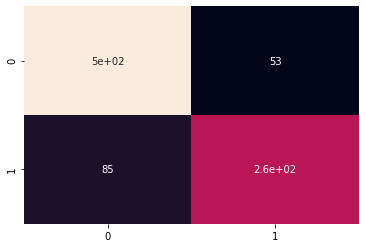

In [43]:
sns.heatmap(cm,annot=True,cbar=False)
plt.show()

In [44]:
print(classification_report(Y,meta_learner.predict(preprocessor.fit_transform(X))))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       549
           1       0.83      0.75      0.79       342

    accuracy                           0.85       891
   macro avg       0.84      0.83      0.83       891
weighted avg       0.84      0.85      0.84       891



#### 4.5.2 AUC score and ROC curve

In [45]:
print("AUC = {0}%".format(round(roc_auc_score(Y,meta_learner.predict(preprocessor.fit_transform(X)))*100,2)))

AUC = 82.75%


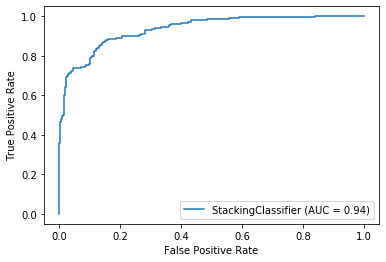

In [46]:
plot_roc_curve(meta_learner,(preprocessor.fit_transform(X)),Y)
plt.show()

# 5. Submission

In [123]:
meta_learner.fit(preprocessor.fit_transform(X),Y)

StackingClassifier(cv=None,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, gamma=None,
                                              gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=0.01,
                                              max_delta_step=None, max_depth=4,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estima...
                          

In [124]:
submission=pd.read_csv("test.csv",usecols=["PassengerId"])
submission["Survived"]=meta_learner.predict(preprocessor.fit_transform(test)).astype(int)

In [125]:
submission.to_csv("mysubmission2.csv",index=False)